### Potential things to change:
Train/test split <br>
activation function <br>
The way in which we evaluate the loss (currently using MSE, but could use something else) <br>
Optimal learning rate and iterations. <br>
General check over. The original framework and code is based on a binary problem, this is regression, need to check things are correct for regression.


In [59]:
import numpy as np
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


california_housing = fetch_california_housing(as_frame=True)

In [60]:
# Converting into a pandas dataframe
df_features = california_housing.data

# TO REMOVE CERTAIN FEATURES
# Keepinng just the latitude and longitude.
# df_features = df_features.iloc[:, 6:]


df_targets = california_housing.target

In [61]:
df_features.head(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22


In [62]:
df_targets.head(2)

0    4.526
1    3.585
Name: MedHouseVal, dtype: float64

In [ ]:
# Standardising the features. NEEDS CHECKING
X = df_features.values
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [64]:
# Checking for missing values in the features  
df_features.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [65]:
# Checking for missing values in the features
df_targets.isnull().sum()

0

In [66]:
# Turning the data into a numpy array
# X = df_features.to_numpy()
y = df_targets.to_numpy().reshape(-1, 1)
print(X.shape)
print(y.shape)

(20640, 8)
(20640, 1)


## Train/Test Split

In [67]:
# 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14448, 8)
(14448, 1)
(6192, 8)
(6192, 1)


## Helper Functions

Sigmoid was used in the workshop, however this was a binary classification problem. Here we are trying to predict house prices and so our output doesnt want to be in the range (0,1). So we use ReLu instead, which is another common activation function. It is defined as f(z) = max(0, z). 

In [68]:
# Activation function
def relu(z):
    return np.maximum(0, z)

# Derivative of the activation function (relu)
def drelu(a):
    return (a > 0).astype(float)

# Mean squared error loss function
def mse_loss(y_pred, y_true, n):
    # Mean squared error (scalar)
    return np.sqrt((1/n)*np.mean((y_pred - y_true)**2))

# ???
def set_seed(seed=0):
    np.random.seed(seed)

def plot_loss_curve(losses, title="Loss curve"):
    plt.figure(figsize=(6,4))
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()


## Forward Propagation

Using 1 hidden layers of 5 neurons (choice was arbitrary), and an output layer of 1 neuron (price prediction).

In [69]:
X_train.shape[1]

8

In [70]:
num_hidden_neurons = 12

In [71]:
W1 = 0.5*np.random.rand(X_train.shape[1], num_hidden_neurons) # (n, 5) for W1 
# Note, in the worksheet, times by 0.5. Maybe change later?
b1 = np.zeros(num_hidden_neurons)

W2 = 0.5*np.random.rand(num_hidden_neurons, 1) # (5, 1) for W2
b2 = np.zeros(1)

In [72]:
def forward(X, W1, b1, W2, b2):
    z1 = X @ W1 + b1
    # Applying activation function (relu) to the hidden layer
    a1 = relu(z1)

    z2 = a1 @ W2 + b2
    y_hat = z2 # Explain why not applying activation function to the output layer (regression problem)
    cache = {"z1": z1, "a1": a1, "z2": z2, "y_hat": y_hat}
    return y_hat, cache

y_hat, cache = forward(X_train, W1, b1, W2, b2)
loss = mse_loss(y_hat, y_train, n=X_train.shape[0])

print("Predictions (y_hat):\n", np.round(y_hat, 3))
print("Loss:", loss)

Predictions (y_hat):
 [[0.441]
 [0.02 ]
 [0.   ]
 ...
 [0.382]
 [0.065]
 [1.019]]
Loss: 0.020538944213535658


(array([1.4427e+04, 1.3000e+01, 4.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.        ,  11.73606492,  23.47212984,  35.20819476,
         46.94425968,  58.68032459,  70.41638951,  82.15245443,
         93.88851935, 105.62458427, 117.36064919]),
 <BarContainer object of 10 artists>)

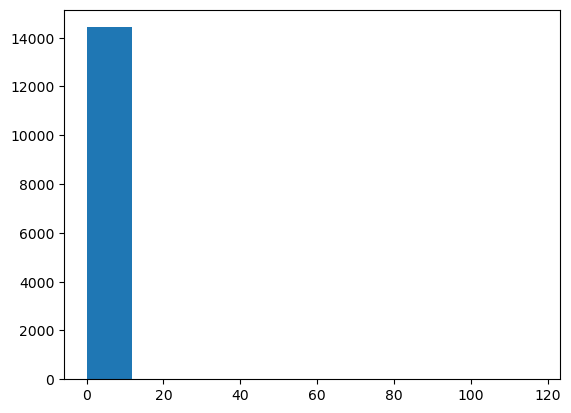

In [73]:
plt.hist(y_hat)

In [74]:
def loss_with_params(X, y, W1, b1, W2, b2):
    y_hat, _ = forward(X, W1, b1, W2, b2)
    return mse_loss(y_hat, y, n=X.shape[0])

def numerical_grad_W2(X, y, W1, b1, W2, b2, eps=1e-5):
    grad = np.zeros_like(W2)
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2_pos = W2.copy(); W2_neg = W2.copy()
            W2_pos[i, j] += eps
            W2_neg[i, j] -= eps
            L_pos = loss_with_params(X, y, W1, b1, W2_pos, b2)
            L_neg = loss_with_params(X, y, W1, b1, W2_neg, b2)
            grad[i, j] = (L_pos - L_neg) / (2*eps)
    return grad

num_gW2 = numerical_grad_W2(X_train, y_train, W1, b1, W2, b2, eps=1e-5)
print("Numerical gradient dL/dW2:\n", np.round(num_gW2, 6))

Numerical gradient dL/dW2:
 [[ 0.002842]
 [ 0.002003]
 [ 0.00182 ]
 [ 0.002458]
 [ 0.001967]
 [ 0.001562]
 [ 0.000697]
 [ 0.00171 ]
 [ 0.002282]
 [-0.000138]
 [ 0.00161 ]
 [ 0.001182]]


In [75]:
def backprop(X, y, W1, b1, W2, b2):
    N = X.shape[0]
    y_hat, cache = forward(X, W1, b1, W2, b2)
    a1 = cache["a1"]

    dL_dyhat = (y_hat - y) / N
    dL_dz2 = dL_dyhat * drelu(y_hat)

    dW2 = a1.T @ dL_dz2
    db2 = np.sum(dL_dz2, axis=0)

    dL_da1 = dL_dz2 @ W2.T
    dL_dz1 = dL_da1 * drelu(a1)

    dW1 = X.T @ dL_dz1
    db1 = np.sum(dL_dz1, axis=0)

    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

grads = backprop(X_train, y_train, W1, b1, W2, b2)
print("Backprop gradient dL/dW2:\n", np.round(grads["dW2"], 6))

Backprop gradient dL/dW2:
 [[ 0.843331]
 [ 0.594246]
 [ 0.540058]
 [ 0.72939 ]
 [ 0.583692]
 [ 0.463565]
 [ 0.206782]
 [ 0.507497]
 [ 0.677246]
 [-0.040899]
 [ 0.477728]
 [ 0.350775]]


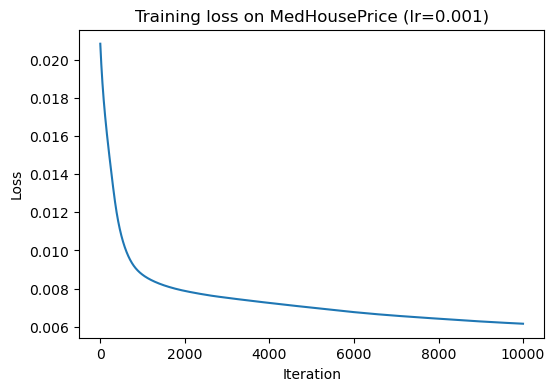

[0.02083590873606047, 0.020785781435310215, 0.020736168408362256, 0.02068703236862194, 0.020638362881464995, 0.020590161461613143, 0.020542429616205254, 0.020495149007436576, 0.020448350671754413, 0.020401989556343543, 0.020356071209233474, 0.020310586223214442, 0.020265518042254432, 0.020220876533502404, 0.020176665171153088, 0.020132867675833877, 0.020089427373234266, 0.020046405797591472, 0.020003741550331626, 0.0199614384726547, 0.019919513938559175, 0.019877995635696685, 0.019836821494996916, 0.019796012678963592, 0.019755582527193845, 0.019715508203116763, 0.01967578212371421, 0.019636405750457143, 0.019597331343605577, 0.01955859562535932, 0.01952015358717401, 0.019481986667514835, 0.01944415224780723, 0.019406643729513885, 0.019369447744698155, 0.01933256115272445, 0.01929593086628979, 0.01925958751257386, 0.0192235392815032, 0.019187782480998797, 0.019152314918297785, 0.019117113357509832, 0.01908218633697085, 0.019047504713700845, 0.019013052404937104, 0.01897885531469564, 0.

In [76]:
def train_NN(X, y, hidden=num_hidden_neurons, lr=1.0, iters=4000, seed=2):
    set_seed(seed)
    W1 = 0.5*np.random.randn(X.shape[1], hidden)
    b1 = np.zeros(hidden)
    W2 = 0.5*np.random.randn(hidden, 1)
    b2 = np.zeros(1)

    

    losses = []
    for t in range(iters):
        y_hat, _ = forward(X, W1, b1, W2, b2)
        L = mse_loss(y_hat, y, n=X.shape[0])
        losses.append(L)

        grads = backprop(X, y, W1, b1, W2, b2)
        W1 -= lr * grads["dW1"]
        b1 -= lr * grads["db1"]
        W2 -= lr * grads["dW2"]
        b2 -= lr * grads["db2"]

    return W1, b1, W2, b2, losses

lr = 0.001   # TODO: try 0.1, 0.5, 1.0, 2.0
iters = 10000

W1_t, b1_t, W2_t, b2_t, losses = train_NN(X_train, y_train, hidden=num_hidden_neurons, lr=lr, iters=iters, seed=2)
plot_loss_curve(losses, title=f"Training loss on MedHousePrice (lr={lr})")
print(losses)
y_hat, _ = forward(X_train, W1_t, b1_t, W2_t, b2_t)
print("Final predictions:", np.round(y_hat.T, 3))
print("Final loss:", losses[-1])

## Testing the model

The parameters of the model are W1_t, b1_t, W2_t, b2_t. We can use these to make predictions on the test set and evaluate the performance of the model.

In [78]:
def predict(X, W1, b1, W2, b2):
    y_hat, _ = forward(X, W1, b1, W2, b2)
    return y_hat

y_pred_test = predict(X_test, W1_t, b1_t, W2_t, b2_t)

test_loss = mse_loss(y_pred_test, y_test, n=X_test.shape[0])
print("Test loss:", test_loss)

print(y_test-y_pred_test)
print(y_pred_test)


Test loss: 0.009445873421193577
[[-0.3209664 ]
 [-0.80959933]
 [ 2.29703983]
 ...
 [ 0.38345384]
 [-0.93269485]
 [ 0.5611623 ]]
[[0.7979664 ]
 [1.26759933]
 [2.70297017]
 ...
 [1.80054616]
 [2.12669485]
 [1.5368377 ]]
